In [1]:
import tempfile
from collections import Counter

import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
from anndata import AnnData
# import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
# ignore warnings
import warnings
import pandas as pd
import numpy    as np
import os
import tempfile
import torch.functional as F
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import scvi
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime

# set pandas display options
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")
# limit show df size
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
np.set_printoptions(threshold=100) 
np.random.seed(0)



/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_gene_likelihood(adata):
    """
    Determines the appropriate gene likelihood distribution for the SCVI model 
    based on the properties of the input AnnData object.
    
    Parameters:
    - adata: AnnData object containing single-cell RNA-seq data.

    Returns:
    - str: Selected gene likelihood distribution ("nb", "zinb", "poisson").
    """
    
    # Check for zero-inflation by counting the proportion of zero values in the data
    zero_proportion = (adata.X == 0).sum() / adata.X.size
    
    # Select likelihood based on zero inflation and count properties
    if zero_proportion > 0.4:
        gene_likelihood = "zinb"  # Zero-Inflated Negative Binomial for high zero-inflation
    elif adata.X.mean() < 5:
        gene_likelihood = "poisson"  # Poisson for low-count data
    else:
        gene_likelihood = "nb"  # Negative Binomial for typical gene expression
    
    print(f"Selected gene likelihood: {gene_likelihood}")
    return gene_likelihood

In [3]:
save_dir = 'data/totalVI'
# adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir)
adata = scvi.data.spleen_lymph_cite_seq(save_path=save_dir)
adata.obsm['protein_expression'].shape
adata


INFO     File data/totalVI/sln_111.h5ad already downloaded                                                         
INFO     File data/totalVI/sln_208.h5ad already downloaded                                                         


AnnData object with n_obs × n_vars = 30474 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    obsm: 'isotypes_htos', 'protein_expression'

In [4]:
sc.read_10x_h5('/home/barroz/Downloads/10k_PBMCs_TotalSeq_B_3p_raw_feature_bc_matrix.h5')

AnnData object with n_obs × n_vars = 2421702 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [5]:
adata.obsm['protein_expression'].shape
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
adata_rna.obsm.pop('protein_expression')
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_prot,     adata_rna

(AnnData object with n_obs × n_vars = 30474 × 110
     obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch',
 AnnData object with n_obs × n_vars = 30474 × 13553
     obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
     obsm: 'isotypes_htos')

In [6]:
adata_prot

AnnData object with n_obs × n_vars = 30474 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'

In [7]:
# plot protein expression pca and rna expression pca
# sc.pp.pca(adata_prot)
# sc.pp.pca(adata_rna)
# sc.pl.pca(adata_prot)
# sc.pl.pca(adata_rna)
# take a subset of the data using scanpy to a new anndata object


In [8]:
# Updated cell type mapping with all specified types
cell_type_mapping = {
    'Activated CD4 T': 'T cells',
    'B1 B': 'B cells',
    'CD122+ CD8 T': 'T cells',
    'CD4 T': 'T cells',
    'CD8 T': 'T cells',
    'Erythrocytes': 'Red blood cells',
    'GD T': 'T cells',
    'ICOS-high Tregs': 'Regulatory T cells',
    'Ifit3-high B': 'B cells',
    'Ifit3-high CD4 T': 'T cells',
    'Ifit3-high CD8 T': 'T cells',
    'Ly6-high mono': 'Monocytes',
    'Ly6-low mono': 'Monocytes',
    'MZ B': 'B cells',
    'MZ/Marco-high macrophages': 'Macrophages',
    'Mature B': 'B cells',
    'Migratory DCs': 'Dendritic cells',
    'NK': 'Natural killer cells',
    'NKT': 'Natural killer T cells',
    'Neutrophils': 'Neutrophils',
    'Plasma B': 'B cells',  # Added missing type
    'Red-pulp macrophages': 'Macrophages',
    'Transitional B': 'B cells',
    'Tregs': 'Regulatory T cells',
    'cDC1s': 'Conventional dendritic cells',
    'cDC2s': 'Conventional dendritic cells',
    'pDCs': 'Plasmacytoid dendritic cells'
}

# Map the specific cell types to major cell types and add as a new column in obs
adata_rna.obs['major_cell_types'] = pd.Categorical( adata_rna.obs['cell_types'].map(cell_type_mapping))
adata_prot.obs['major_cell_types'] =pd.Categorical(  adata_prot.obs['cell_types'].map(cell_type_mapping))
major_to_minor_dict ={}
# from major to     minor dict
for k,v in cell_type_mapping.items():
    if v not in major_to_minor_dict:
        major_to_minor_dict[v] = [k]
    else:
        major_to_minor_dict[v].append(k)
    
[len(x) for x in major_to_minor_dict.values()]

[7, 6, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1]

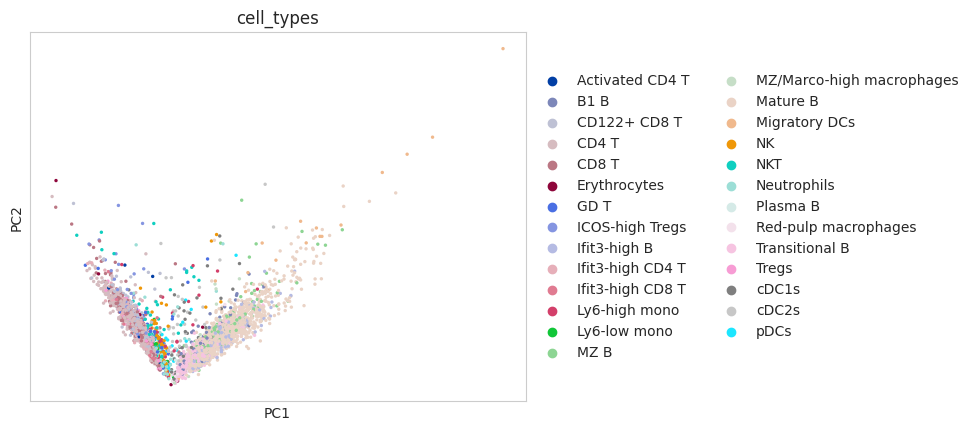

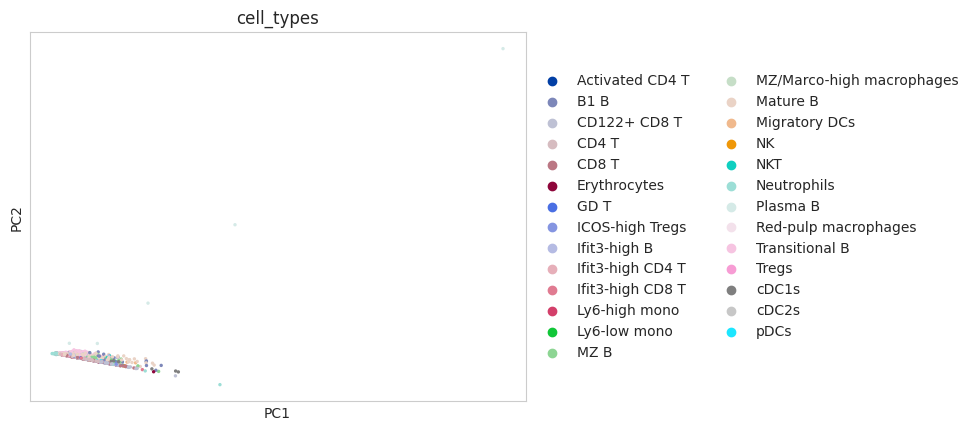

In [9]:
adata_prot_subset = sc.pp.subsample(adata_prot, n_obs=5000,copy=    True)
adata_rna_subset = sc.pp.subsample(adata_rna, n_obs=5000,copy=    True)
sc.pp.pca(adata_prot_subset)
sc.pp.pca(adata_rna_subset)
sc.pl.pca(adata_prot_subset,color='cell_types')
sc.pl.pca(adata_rna_subset,color='cell_types')


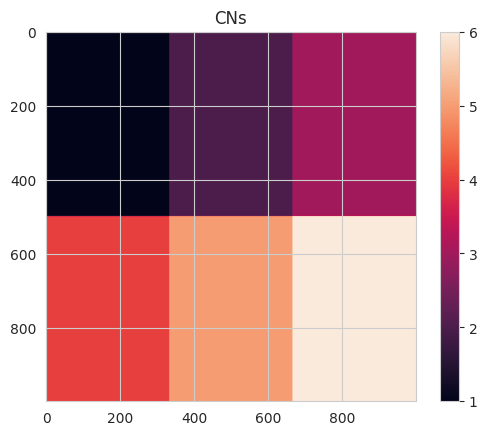

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the dimensions
horizontal_splits = [0, 500, 1000]
vertical_splits = [0, 333, 666, 1000]

# Define the regions using nested loops and product()
regions = [
    list(product(range(horizontal_splits[i], horizontal_splits[i + 1]),
                 range(vertical_splits[j], vertical_splits[j + 1])))
    for i in range(len(horizontal_splits) - 1)
    for j in range(len(vertical_splits) - 1)
]

# Create a blank board
board = np.zeros((1000, 1000))

# Assign different values to each region for visualization
for idx, region in enumerate(regions):
    # Convert each region's list of tuples to an array to index properly
    coords = np.array(region)
    board[coords[:, 0], coords[:, 1]] = idx + 1  # Assign different values for each region

# Visualize the board to confirm each region
plt.imshow(board)
plt.title('CNs')
plt.colorbar()
plt.show()


In [11]:
# set x and y coor for each cell in dataset and place it in the adata_prot_subset
adata_prot_subset.obs['X'] = np.random.randint(0, 1000, adata_prot_subset.n_obs)
adata_prot_subset.obs['Y'] = np.random.randint(0, 1000, adata_prot_subset.n_obs)

# map minor cell types of B cells to diffrene neighboring regions by samplesing from the regions
# and placing the cells in the regions
# make a minor cell type to region dict
minor_to_region_dict = {}
for i, cell_type in enumerate(major_to_minor_dict['B cells']):
    minor_to_region_dict[cell_type] = i

# Place the cells in the regions
for cell_type, region in minor_to_region_dict.items():
    # Get the indices of the cells of the current cell type
    cell_indices = adata_prot_subset.obs['cell_types'] == cell_type
    # Get the coordinates of the cells
    coords = np.array(regions[region])
    # Place the cells in the regions
    adata_prot_subset.obs['X'][cell_indices] = np.random.choice(coords[:, 0], sum(cell_indices))
    adata_prot_subset.obs['Y'][cell_indices] = np.random.choice(coords[:, 1], sum(cell_indices))
    
adata_prot_subset.obsm['X_spatial'] = np.array(adata_prot_subset.obs[['X', 'Y']])

In [12]:
adata_prot_subset

AnnData object with n_obs × n_vars = 5000 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'X', 'Y'
    uns: 'pca', 'cell_types_colors'
    obsm: 'X_pca', 'X_spatial'
    varm: 'PCs'

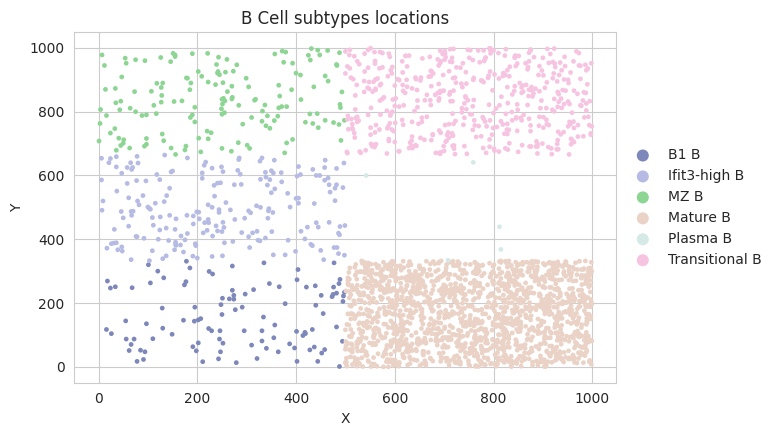

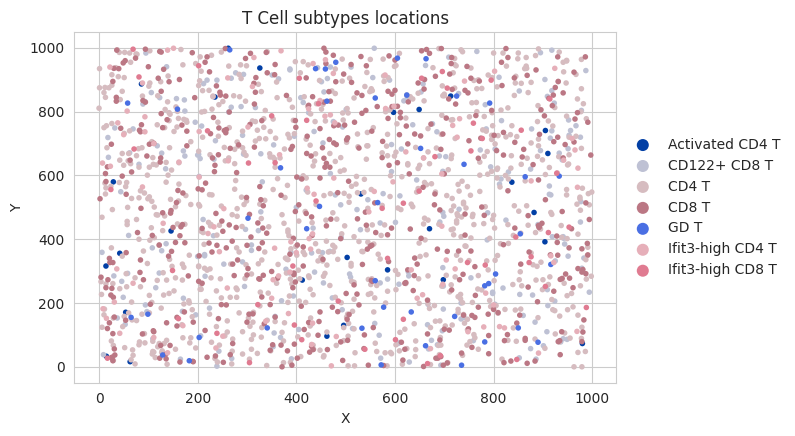

In [13]:
sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='T cells'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')


In [14]:
# get all unieq from connectivities sparse matrix

In [15]:
sc.pp.neighbors(adata_prot_subset,use_rep='X_spatial')
connectivities = adata_prot_subset.obsp['connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))


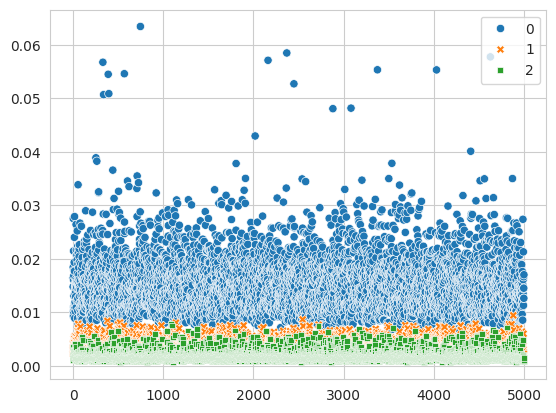

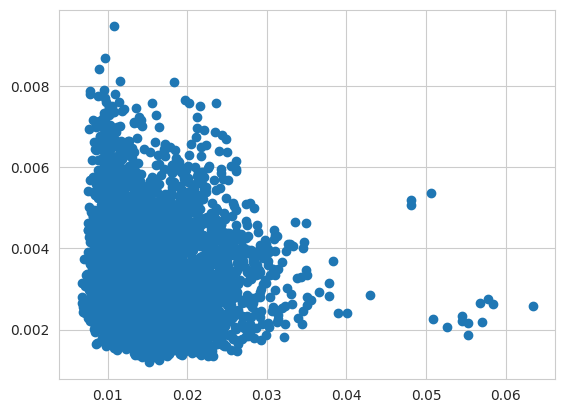

In [16]:
import scipy
neighbor_sums = connectivities.dot(adata_prot_subset.X) # get the sum of all neighbors
# np.array(connectivities.todense()[connectivities.todense()!=0].flatten())
neighbor_means = neighbor_sums/neighbor_sums.sum(1)[:,np.newaxis] # normalize
sns.scatterplot(neighbor_means[:,:3])
plt.show()
plt.scatter(neighbor_means[:,0],neighbor_means[:,1])



In [17]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import zscore

# Standardize the data (z-score normalization)
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import zscore

# Standardize the data
normalized_data = zscore(neighbor_means, axis=0)
# Add the neighborhood vectors to obsm (observation-wise multidimensional annotations)
adata_prot_subset.obsm['X_neighborhood'] = normalized_data


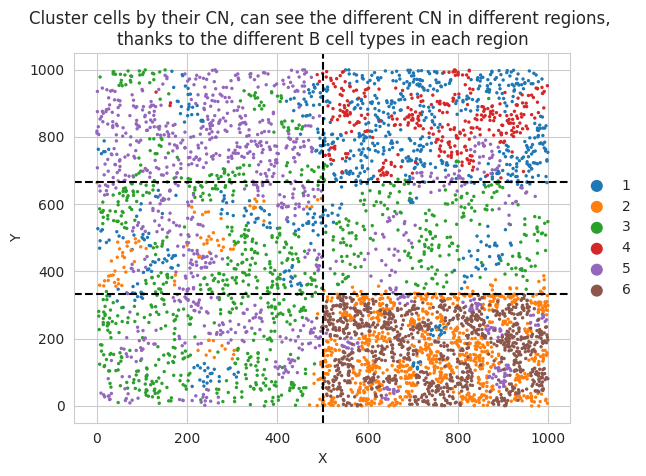

In [116]:

# Perform hierarchical clustering
Z = linkage(normalized_data, method='ward')
initial_labels = fcluster(Z, t=6, criterion='maxclust')

# Calculate centroids of the initial hierarchical clusters
centroids = np.array([normalized_data[initial_labels == k].mean(axis=0) for k in np.unique(initial_labels)])

# Run K-means on the centroids with desired cluster count (6 in this case)
kmeans = KMeans(n_clusters=6, random_state=0).fit(centroids)

# Map the initial labels to the K-means labels
final_labels = np.array([kmeans.labels_[np.where(np.unique(initial_labels) == label)[0][0]] + 1 for label in initial_labels])
adata_prot_subset.obs['CN'] = pd.Categorical(final_labels)
adata_rna_subset.obs['CN'] = pd.Categorical(final_labels)
# Plot the clusters

# Generate a color palette with as many colors as you have clusters (6 in this case)
palette = sns.color_palette("tab10", 6)  # "tab10" is a good color map, you can choose others too
adata_prot_subset.uns['spatial_clusters_colors'] = palette.as_hex()  # Save as hex color codes
fig, ax = plt.subplots()

sc.pl.scatter(
    adata_prot_subset, 
    x='X', y='Y', 
    color='ֻֻֻCN', 
    title='Cluster cells by their CN, can see the different CN in different regions, \nthanks to the different B cell types in each region',
    ax=ax,  # Use the ax created above
    show=False  # Prevent scanpy from showing the plot immediately
)
for x in horizontal_splits[1:-1]:  # Exclude the edges to avoid border doubling
    ax.axvline(x=x, color='black', linestyle='--')

for y in vertical_splits[1:-1]:  # Exclude the edges to avoid border doubling
    ax.axhline(y=y, color='black', linestyle='--')
plt.show()


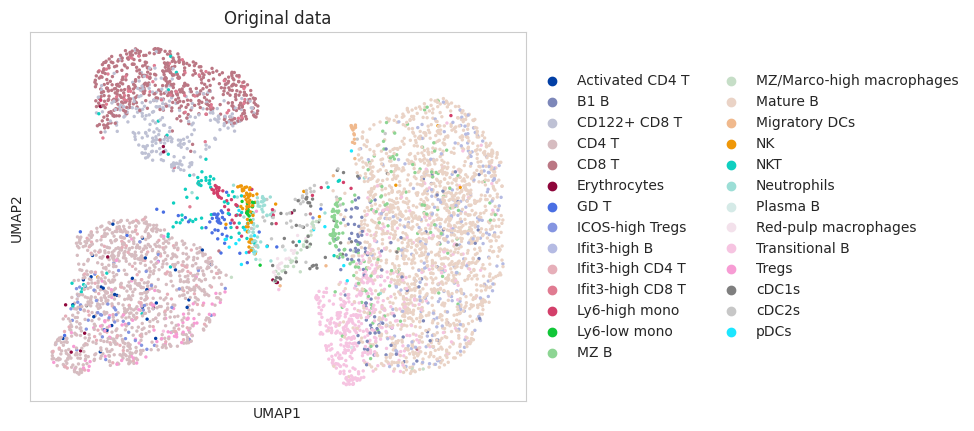

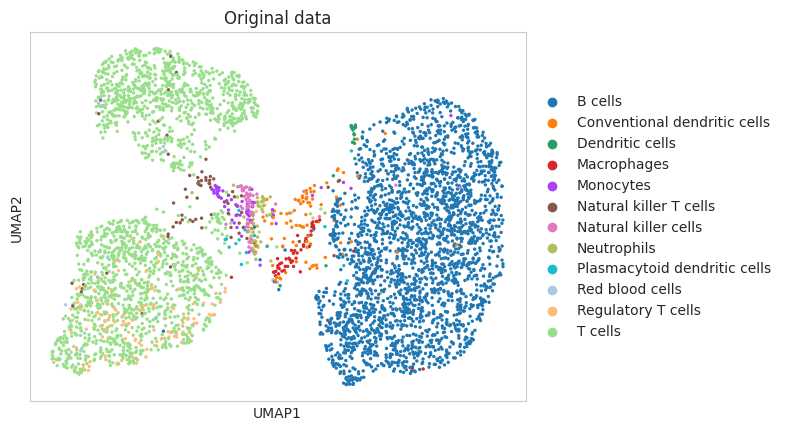

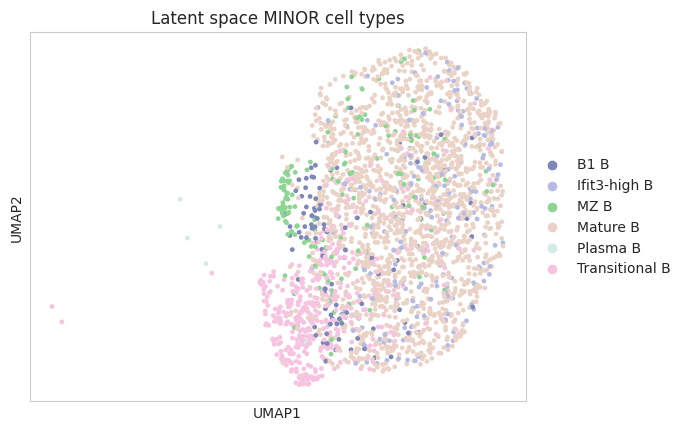

In [117]:
sc.pp.neighbors(adata_prot_subset,key_added='original_neighbors')
sc.tl.umap(adata_prot_subset,neighbors_key='original_neighbors')
sc.pl.umap(adata_prot_subset, color="cell_types",neighbors_key='original_neighbors',title='Original data')
sc.pl.umap(adata_prot_subset, color="major_cell_types",neighbors_key='original_neighbors',title='Original data')
sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types'] =='B cells'], color="cell_types",neighbors_key='latent_space_neighbors',title='Latent space MINOR cell types')



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Selected gene likelihood: zinb
Epoch 1/1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=1, train_loss_step=6.57e+3, train_base_loss=6.57e+3, train_cn_loss=14.1, train_loss_epoch=7.68e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=1, train_loss_step=6.57e+3, train_base_loss=6.57e+3, train_cn_loss=14.1, train_loss_epoch=7.68e+3]


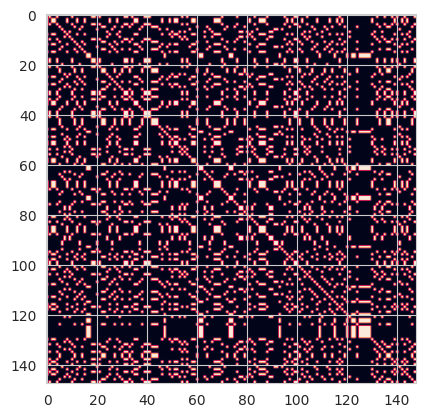

In [123]:
class CNTrainingPlan(TrainingPlan):
    def __init__(self, module, **kwargs):
        super().__init__(module, **kwargs)

    def training_step(self, batch, batch_idx):
        # Call the base training step for standard loss computation
        base_loss = super().training_step(batch, batch_idx)

        # Access the labels for contrastive loss
        # cell_type_info = batch["labels"].squeeze()  # Or use 'extra_categorical_covs' if appropriate
        extra_categorical_covs = batch["extra_categorical_covs"].squeeze() 
        major_cell_type = extra_categorical_covs[:]
        cell_neighborhood_info = batch["labels"].squeeze() 
        # cell_type_info = cell_type_info.cpu().numpy()
        # cn_category = torch.tensor([adata.uns['cn_profiles_dict'][i+1] for i in cell_type_info[:,1]])

        # cn_category = torch.tensor([adata.uns['cn_profiles_dict'][i] for i in cell_type_info[:,0]])
        # Get latent embeddings from the encoder
        inference_outputs = self.module.inference(
            batch["X"], batch_index=batch["batch"], n_samples=1
        )
        latent_embeddings = inference_outputs["z"].squeeze(0)  # Shape: (num_cells, latent_dim)

        # Compute pairwise distances
        distances = torch.cdist(latent_embeddings, latent_embeddings, p=2)

        # Exclude self-pairs
        num_cells = cell_neighborhood_info.shape[0]
        diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=cell_neighborhood_info.device)
        # this will give us each row represents a item in the array, and each col is whether it is the same as the items in that index of the col
        # this way we get for each cell(a row) which other cells (index of each item in the row, which is the col) are matching
        # so if we got 1,2,1, we will get [[1,0,1],[0,1,0],[1,0,1]]
        same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
        same_major_cell_type  = major_cell_type.unsqueeze(0) == major_cell_type.unsqueeze(1)
    
        if batch["batch"][0].item()==0: # show the mask only for the first batch to make sure it is working as expected
            plt.imshow(same_cn_mask.cpu().numpy())
        distances = distances.masked_fill(diagonal_mask, 0) 

        same_major_type_same_cn_mask = (same_major_cell_type * same_cn_mask).type(torch.bool)
        same_major_type_different_cn_mask = (same_major_cell_type * ~same_cn_mask).type(torch.bool)
        different_major_type_same_cn_mask = (~same_major_cell_type * same_cn_mask).type(torch.bool)
        different_major_type_different_cn_mask = (~same_major_cell_type * ~same_cn_mask).type(torch.bool)
        
        same_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        same_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        
        same_major_type_same_cn_loss = (distances ** 2) * same_major_type_same_cn_mask
        same_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2)* same_major_type_different_cn_mask
        different_major_type_same_cn_loss = ((10 - distances).clamp(min=0) ** 2)* different_major_type_same_cn_mask
        different_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * different_major_type_different_cn_mask
        # for debugging only: # todo remove this same_cn_loss, it is not valid
        same_cn_loss = (distances ** 2)*same_cn_mask 
        same_major_type_loss = (distances ** 2)*same_major_cell_type
        # end of debugging
        
        positive_loss =  same_major_type_same_cn_loss
        
        # TODO change to temperature, learnable?
        negative_loss = different_major_type_different_cn_loss + different_major_type_same_cn_loss + 2*same_major_type_different_cn_loss   
        cn_loss = (positive_loss.sum() + negative_loss.sum()) / (num_cells * (num_cells - 1))

        # Combine losses
        total_loss = base_loss + 100 * cn_loss

        # Log losses
        self.log("train_base_loss", base_loss, prog_bar=True)
        self.log("train_cn_loss", cn_loss, prog_bar=True)

        return total_loss



SCVI.setup_anndata(
    adata_rna_subset, 
    labels_key="CN",                # Use CN as label information
    categorical_covariate_keys=["major_cell_types"] , # Register cell types as a covariate
    # obsm_key="cn_vector"
)

model = scvi.model.SCVI(
    adata_rna_subset, gene_likelihood=select_gene_likelihood(adata_rna_subset),
    n_layers=1 ,n_latent=10, n_hidden=128,
)  


model._training_plan_cls = CNTrainingPlan # CRUCIAL: Set the training plan to the custom class
model.train(
    check_val_every_n_epoch=1,
    max_epochs=1,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    batch_size= 256,
    # logger=logger,  
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.27it/s, v_num=1, train_loss_step=4.59e+3, train_base_loss=4.59e+3, train_cn_loss=8.06, train_loss_epoch=4.5e+3] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s, v_num=1, train_loss_step=4.59e+3, train_base_loss=4.59e+3, train_cn_loss=8.06, train_loss_epoch=4.5e+3]


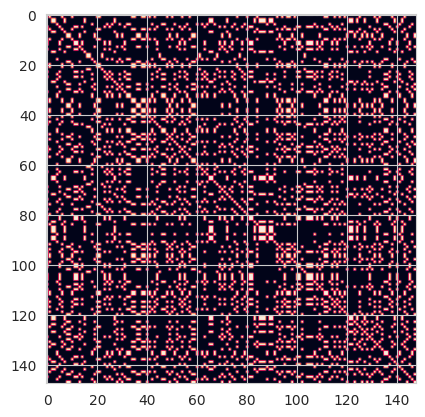

In [124]:
experiment_name =  datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
# logger = TensorBoardLogger("tb_logs", name=experiment_name)

model.train(
    check_val_every_n_epoch=50,
    max_epochs=10,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    batch_size= 256,
    # logger=logger,  
)

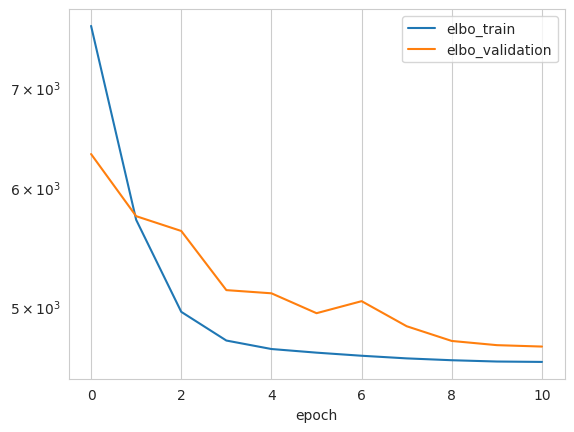

In [125]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[:].plot(logy=True)  # exclude first 10 epochs
plt.show()

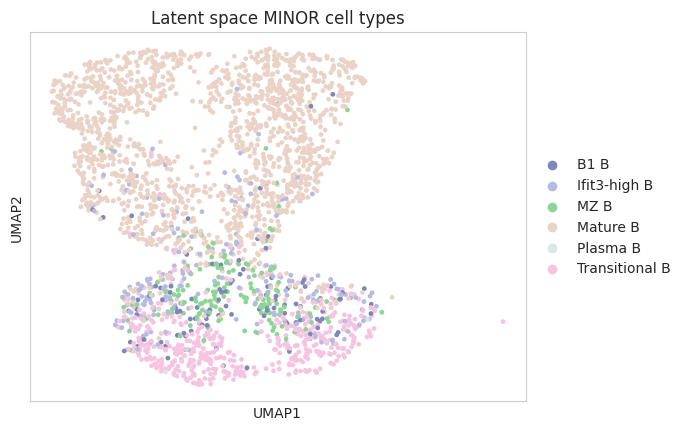

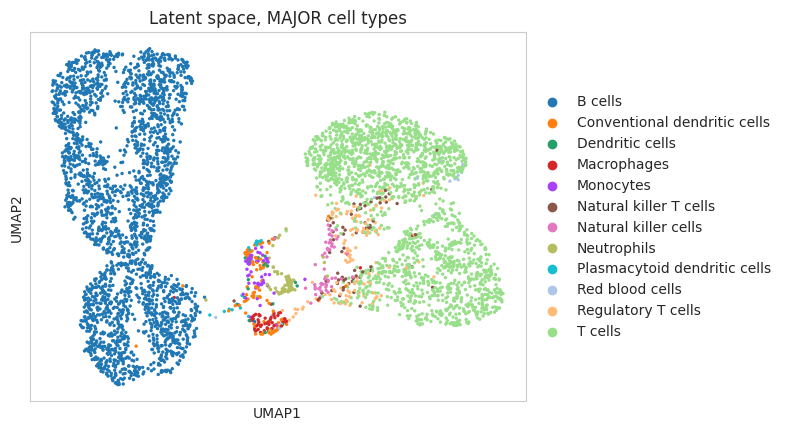

In [126]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent

sc.pp.neighbors(adata_rna_subset, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.tl.umap(adata_rna_subset,neighbors_key='latent_space_neighbors')

sc.pl.umap(adata_rna_subset[adata_rna_subset.obs['major_cell_types'] =='B cells'], color="cell_types",neighbors_key='latent_space_neighbors',title='Latent space MINOR cell types')
sc.pl.umap(adata_rna_subset, color="major_cell_types",neighbors_key='latent_space_neighbors',title='Latent space, MAJOR cell types')

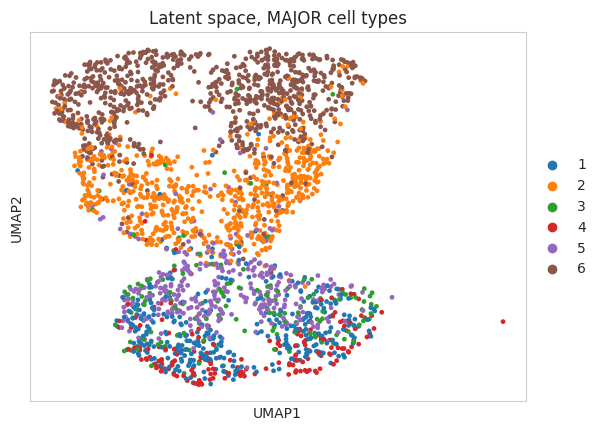

In [127]:
sc.pl.umap(adata_rna_subset[adata_rna_subset.obs['major_cell_types'] =='B cells'], color="CN",neighbors_key='latent_space_neighbors',title='Latent space, MAJOR cell types')
